Noah Anderson  
July 15th, 2024  

# Load Libraries

In [1]:
from efficientnet_pytorch import EfficientNet
from torchvision import  transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
import os
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import multiprocessing
from torch.utils.data import DataLoader, ConcatDataset, random_split
import numpy as np
import torch
from torchvision.transforms import Compose, RandomRotation, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize, GaussianBlur
from PIL import Image
import torch
from sklearn.metrics import precision_score, recall_score, f1_score




# Define Transformations and Read Data

In [2]:
# Center crop and resize to 224 by 224 and convert to tensor
data_transform = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor()
])

# Define data path
data_dir = "mendeley_data"

# Read in the data with ImageFolder
data = ImageFolder(data_dir, transform = data_transform)

# Shuffling and Re-Splitting Test and Train

In [3]:
# Set seed for reproducibility
torch.manual_seed(42)  # You can use any integer value as the seed

# Define the sizes for the splits
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

# Split the dataset into new train and test sets (e.g., 90% train, 10% test)
trainset, valset, testset = random_split(data, [train_size, val_size, test_size])

# Define batchsize
batch_size = 32  

# DataLoaders
train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 6, pin_memory = True)
val_loader = DataLoader(valset, batch_size = batch_size * 2, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(testset, batch_size = batch_size * 2, num_workers = 6, pin_memory = True)

# Change Device to GPU

In [4]:

# Set device to CPU
device = torch.device("mps") # try runnign mps next
print(f'Using device: {device}')

multiprocessing.set_start_method("fork")

Using device: mps


# Set Model Features

In [5]:


# Load the pre-trained EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')


# Modify the last layer to match the number of classes in your dataset
num_classes = len(data.classes)
model._fc = torch.nn.Linear(model._fc.in_features, num_classes)


# Move model to the device (CPU in this case)
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

# Select Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = .001) # Learning rate used in Kaur et. al

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.3, patience = 2)

# Define accuracy function
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = (preds == labels).sum().item()
    return corrects


Loaded pretrained weights for efficientnet-b0


# Train Model

In [6]:

# Set initial values for epoch tracking lists
train_losses = [] # Training loss list
val_losses = [] # Validation loss list
train_accuracies = [] # Training accuarcy list
val_accuracies = [] # Validation accuracy list
num_epochs = 30 # Define number of epochs
min_valid_loss = np.inf # Initialize minimum validation loss as infinite
max_valid_accuracy = 0 # Initalize maximum validation accuracy as 0

# Epoch training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0 # Initialize training loss
    running_corrects = 0

    for batch_images, batch_labels in train_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)  # Move data to the GPU
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_images)  # Forward pass
        loss = criterion(outputs, batch_labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        
        train_loss += loss.item() * batch_images.size(0)  # Accumulate loss
        running_corrects += calculate_accuracy(outputs, batch_labels)  # Accumulate correct predictions
    
    print("     Epoch training complete, now starting validation")

    ### Validation
    val_loss = 0.0
    val_corrects = 0
    model.eval()
    with torch.no_grad():  # Disable gradient calculation
        for batch_images, batch_labels in val_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)  # Move data to the GPU
            
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item() * batch_images.size(0)  # Accumulate loss
            val_corrects += calculate_accuracy(outputs, batch_labels)  # Accumulate correct predictions

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = running_corrects / len(train_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)

    print(f'Epoch {epoch + 1} \t\t Training Loss: {train_loss:.4f} \t\t Validation Loss: {val_loss:.4f} \t\t Training Accuracy: {train_acc:.4f} \t\t Validation Accuracy: {val_acc:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if min_valid_loss > val_loss:
        print(f'Validation loss decreased({min_valid_loss:.6f}--->{val_loss:.6f}) \t Saving the model')
        min_valid_loss = val_loss
        torch.save(model.state_dict(), 'saved_models/saved_model.pth')

    if val_acc > max_valid_accuracy:
        print(f'Validation accuracy increased ({max_valid_accuracy:.6f})--->{val_acc} \t Saving the best accuracy model')
        max_valid_accuracy = val_acc
        torch.save(model.state_dict(), 'saved_models/best_accuracy_model.pth')
        
    scheduler.step(val_loss)



     Epoch training complete, now starting validation
Epoch 1 		 Training Loss: 0.1921 		 Validation Loss: 1.8668 		 Training Accuracy: 0.9379 		 Validation Accuracy: 0.5541
Validation loss decreased(inf--->1.866763) 	 Saving the model
Validation accuracy increased (0.000000)--->0.5541310541310541 	 Saving the best accuracy model
     Epoch training complete, now starting validation
Epoch 2 		 Training Loss: 0.0729 		 Validation Loss: 0.1751 		 Training Accuracy: 0.9753 		 Validation Accuracy: 0.9345
Validation loss decreased(1.866763--->0.175090) 	 Saving the model
Validation accuracy increased (0.554131)--->0.9344729344729344 	 Saving the best accuracy model
     Epoch training complete, now starting validation
Epoch 3 		 Training Loss: 0.0607 		 Validation Loss: 0.1441 		 Training Accuracy: 0.9810 		 Validation Accuracy: 0.9387
Validation loss decreased(0.175090--->0.144060) 	 Saving the model
Validation accuracy increased (0.934473)--->0.9387464387464387 	 Saving the best accuracy 

# Test Model

### Test model after all epochs

In [7]:

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.cpu().numpy())  # Convert predictions to CPU numpy array
        true_labels.extend(batch_labels.cpu().numpy())  # Convert true labels to CPU numpy array
        
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Calculate precision score
precision = precision_score(true_labels, predictions, average='macro')
print(f'Precision Score: {precision:.4f}')

# Calculate recall score
recall = recall_score(true_labels, predictions, average='macro')
print(f'Recall Score: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print(f'F1 Score: {f1:.4f}')


Validation Accuracy: 99.43%
Precision Score: 0.9948
Recall Score: 0.9942
F1 Score: 0.9945


### Test model with the lowest validation loss

In [8]:
model.load_state_dict(torch.load('saved_models/saved_model.pth'))


model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.cpu().numpy())  # Convert predictions to CPU numpy array
        true_labels.extend(batch_labels.cpu().numpy())  # Convert true labels to CPU numpy array
        
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Calculate precision score
precision = precision_score(true_labels, predictions, average='macro')
print(f'Precision Score: {precision:.4f}')

# Calculate recall score
recall = recall_score(true_labels, predictions, average='macro')
print(f'Recall Score: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print(f'F1 Score: {f1:.4f}')

Validation Accuracy: 99.29%
Precision Score: 0.9933
Recall Score: 0.9930
F1 Score: 0.9932


### Test model with best validation accuracy

In [9]:
model.load_state_dict(torch.load('saved_models/best_accuracy_model.pth'))

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.cpu().numpy())  # Convert predictions to CPU numpy array
        true_labels.extend(batch_labels.cpu().numpy())  # Convert true labels to CPU numpy array
        
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Calculate precision score
precision = precision_score(true_labels, predictions, average='macro')
print(f'Precision Score: {precision:.4f}')

# Calculate recall score
recall = recall_score(true_labels, predictions, average='macro')
print(f'Recall Score: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print(f'F1 Score: {f1:.4f}')

Validation Accuracy: 99.57%
Precision Score: 0.9960
Recall Score: 0.9957
F1 Score: 0.9959


# Plot Training and Validation and Loss and Accuracy

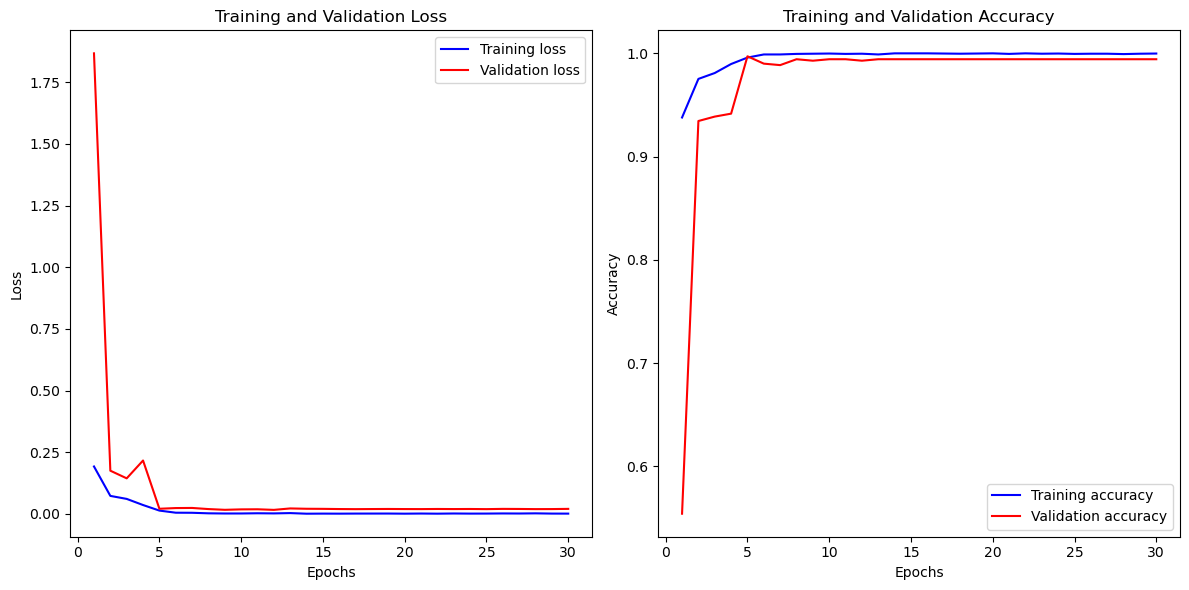

In [10]:
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(12, 6))

epochs = range(1, len(train_losses) + 1)


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()